# Excercises 
# 1. Tune the network
Run the experiment below, explore the different parameters (see suggestions below) and study the result with tensorboard. 
Make a single page (1 a4) report of your findings. Use your visualisation skills to communicate your most important findings.

In [12]:
from mads_datasets import DatasetFactoryProvider, DatasetType

from mltrainer.preprocessors import BasePreprocessor
from mltrainer import imagemodels, Trainer, TrainerSettings, ReportTypes, metrics

import torch.optim as optim
from torch import nn
from tomlserializer import TOMLSerializer

We will be using `tomlserializer` to easily keep track of our experiments, and to easily save the different things we did during our experiments.
It can export things like settings and models to a simple `toml` file, which can be easily shared, checked and modified.

First, we need the data. 

In [13]:
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()
streamers = fashionfactory.create_datastreamer(batchsize=64, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()

2025-10-17 12:12:03.083 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at C:\Users\NvanOort\.cache\mads_datasets\fashionmnist
2025-10-17 12:12:03.085 | INFO     | mads_datasets.base:download_data:124 - File already exists at C:\Users\NvanOort\.cache\mads_datasets\fashionmnist\fashionmnist.pt


In [14]:
# Display the first 5 rows of the train data
batch = next(trainstreamer)
images, labels = batch
for i in range(5):
    print(f"Image {i+1} - Label: {labels[i]}")

Image 1 - Label: 0
Image 2 - Label: 2
Image 3 - Label: 3
Image 4 - Label: 4
Image 5 - Label: 2


In [15]:
import pandas as pd

# Let's take 5 images and labels and put them into a DataFrame for easy viewing
df = pd.DataFrame({
    "image": [images[i].numpy() for i in range(5)],
    "label": [labels[i].item() for i in range(5)]
})
df

,image,label
0,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",0
1,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1...",2
2,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",3
3,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019607...",4
4,"[[[0.0, 0.0, 0.0, 0.003921569, 0.0, 0.01568627...",2


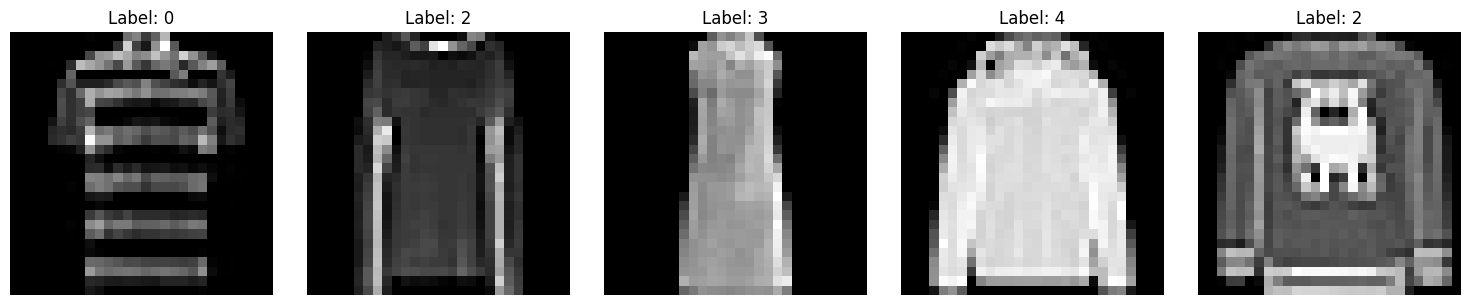

In [16]:
import matplotlib.pyplot as plt

# Visualize the first 5 images with their labels
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Images are shape (1, 28, 28), so squeeze to (28, 28)
    axs[i].imshow(images[i].squeeze(), cmap='gray')
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()


We need a way to determine how well our model is performing. We will use accuracy as a metric.

In [17]:
accuracy = metrics.Accuracy()

You can set up a single experiment.

- We will show the model batches of 64 images, 
- and for every epoch we will show the model 100 batches (trainsteps=100).
- then, we will test how well the model is doing on unseen data (teststeps=100).
- we will report our results during training to tensorboard, and report all configuration to a toml file.
- we will log the results into a directory called "modellogs", but you could change this to whatever you want.

In [40]:
import torch
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=10,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
    optimizer_kwargs={"lr": 0.01, "weight_decay": 1e-05},
)


We will use a very basic model: a model with three linear layers.

In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.units1 = units1
        self.units2 = units2
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, units1),
            nn.ReLU(),
            nn.Linear(units1, units2),
            nn.ReLU(),
            nn.Linear(units2, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(
    num_classes=10, units1=256, units2=256)

I developped the `tomlserializer` package, it is a useful tool to save configs, models and settings as a tomlfile; that way it is easy to track what you changed during your experiments.

This package will 1. check if there is a `__dict__` attribute available, and if so, it will use that to extract the parameters that do not start with an underscore, like this:

In [20]:
{k: v for k, v in model.__dict__.items() if not k.startswith("_")}

{'training': True, 'num_classes': 10, 'units1': 256, 'units2': 256}

This means that if you want to add more parameters to the `.toml` file, eg `units3`, you can add them to the class like this:

```python
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int, units3: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.units1 = units1
        self.units2 = units2
        self.units3 = units3  # <-- add this line
```

And then it will be added to the `.toml` file. Check the result for yourself by using the `.save()` method of the `TomlSerializer` class like this:

In [21]:
tomlserializer = TOMLSerializer()
tomlserializer.save(settings, "settings.toml")
tomlserializer.save(model, "model.toml")

Check the `settings.toml` and `model.toml` files to see what is in there.

You can use the `Trainer` class from my `mltrainer` module to train your model. It has the TOMLserializer integrated, so it will automatically save the settings and model to a toml file if you have added `TOML` as a reporttype in the settings.

In [41]:
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optim.SGD,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-10-17 12:49:32.815 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs\20251017-124932
2025-10-17 12:49:32.817 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:00<00:00, 234.10it/s]
2025-10-17 12:49:33.466 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.3250 test 0.3885 metric ['0.8628']
100%|██████████| 100/100 [00:00<00:00, 274.89it/s]
2025-10-17 12:49:34.088 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.3311 test 0.3936 metric ['0.8588']
2025-10-17 12:49:34.088 | INFO     | mltrainer.trainer:__call__:252 - best loss: 0.3885, current loss 0.3936.Counter 1/10.
100%|██████████| 100/100 [00:00<00:00, 211.77it/s]
2025-10-17 12:49:34.819 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.3315 test 0.3889 metric ['0.8588']
2025-10-17 12:49:34.820 | INFO     | mltrainer.trainer:__call__:252 - best loss: 0.3885, current loss 0.

Now, check in the modellogs directory the results of your experiment.

We can now loop this with a naive approach, called a grid-search (why do you think i call it naive?).

In [ ]:
units = [256, 128, 64]
for unit1 in units:
    for unit2 in units:
        print(f"Units: {unit1}, {unit2}")

Of course, this might not be the best way to search for a model; some configurations will be better than others (can you predict up front what will be the best configuration?).

So, feel free to improve upon the gridsearch by adding your own logic.

In [ ]:
import torch

units = [256, 128, 64]
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

for unit1 in units:
    for unit2 in units:

        model = NeuralNetwork(num_classes=10, units1=unit1, units2=unit2)

        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )
        trainer.loop()


Because we have set the ReportType to TOML, you will find in every log dir a model.toml and settings.toml file.

Run the experiment, and study the result with tensorboard. 

Locally, it is easy to do that with VS code itself. On the server, you have to take these steps:

- in the terminal, `cd` to the location of the repository
- activate the python environment for the shell. Note how the correct environment is being activated.
- run `tensorboard --logdir=modellogs` in the terminal
- tensorboard will launch at `localhost:6006` and vscode will notify you that the port is forwarded
- you can either press the `launch` button in VScode or open your local browser at `localhost:6006`